In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.agents.constant import AllC, AllD
from society.agents.qlearning import DoubleTabularQLearner, TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.simulations.adaptive import AdaptiveSimulation
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]

Run 1:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (57): 36499 (0.9495373610139181, CCCCCCCCCCCCCCCC)
WORST AGENT (228): 28974 (0.4839821314613912, DDCDCCCCDDCCCDCC)


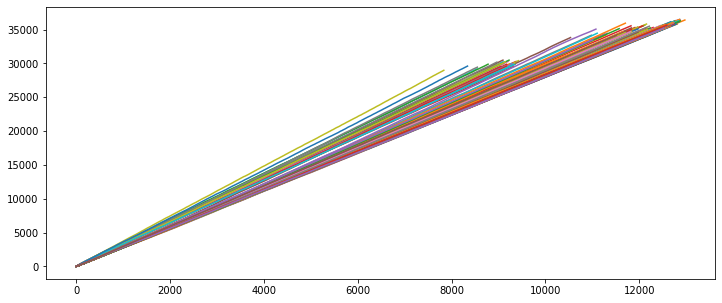

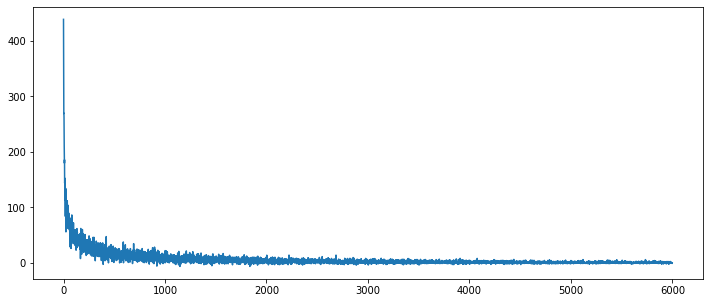

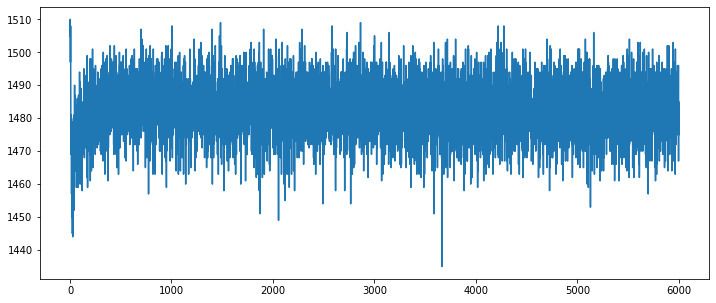

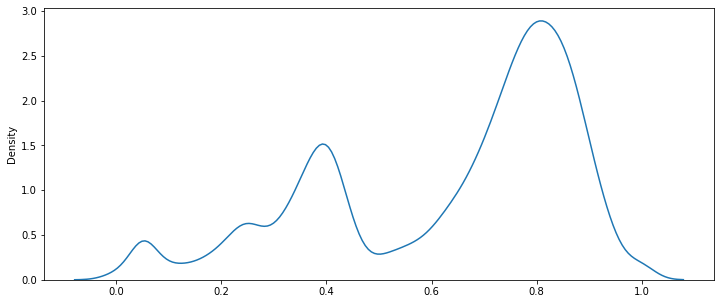

Run 2:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (94): 36911 (0.9473161033797217, CCCCCCCCCCCCCCCC)
WORST AGENT (131): 26823 (0.3244031093836757, DCDCCCCCCCDDCCCC)


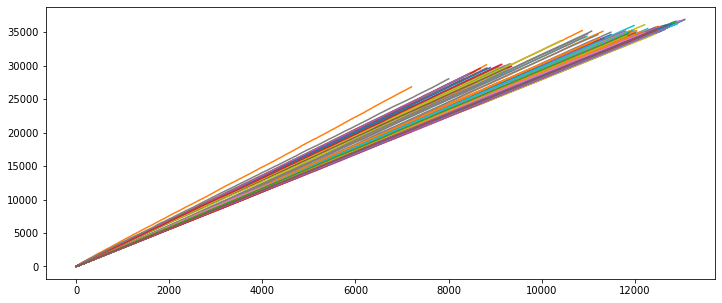

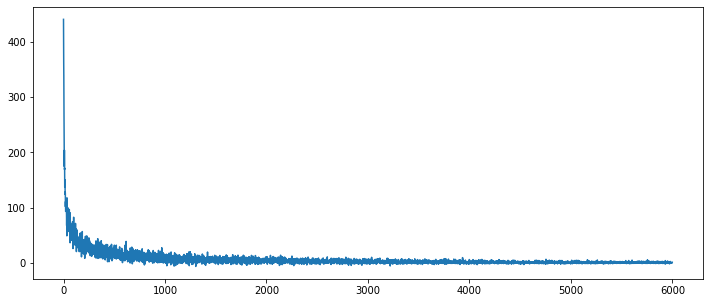

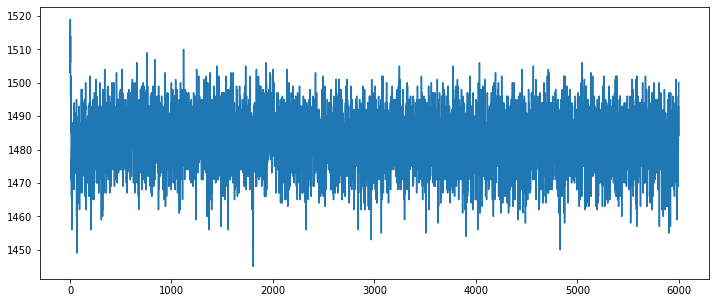

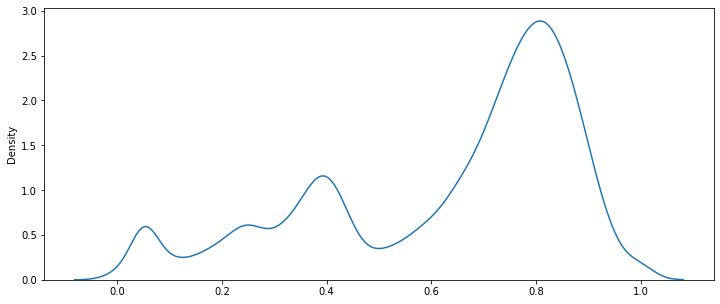

Run 3:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (194): 36764 (0.9467569439101331, CCCCCCCCCCCCCCCC)
WORST AGENT (197): 26002 (0.39557046979865773, DCDCCCCCCCDCCCCC)


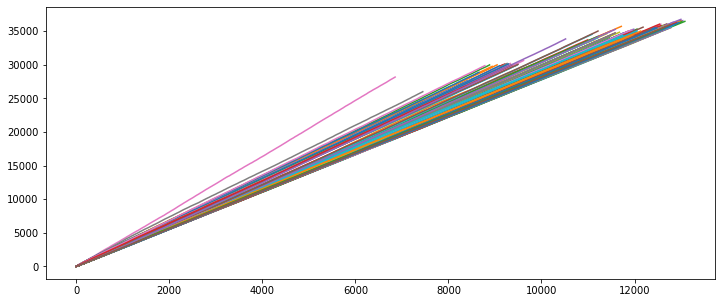

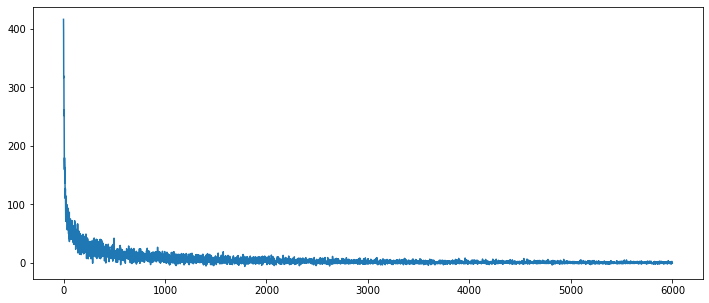

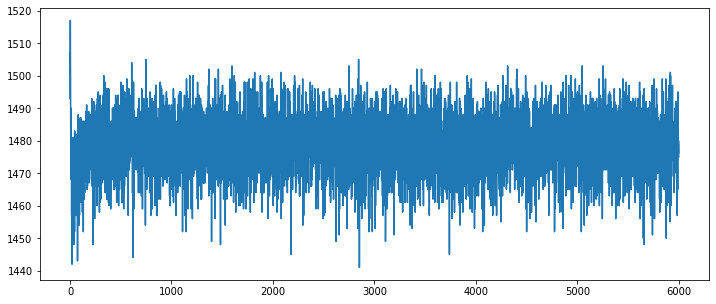

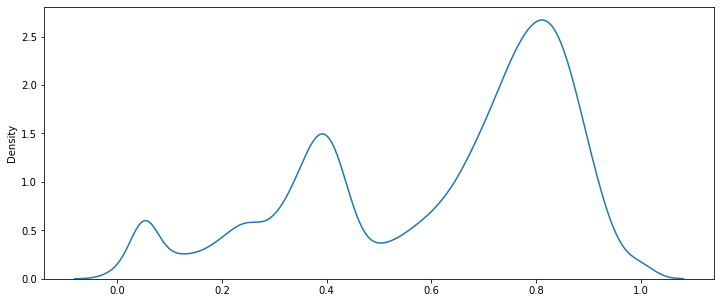

Run 4:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (23): 36700 (0.9433245464413087, CCCCCDCCCCCCCCCD)
WORST AGENT (138): 27355 (0.38253094910591473, DCDDCCCCDDCCCCCC)


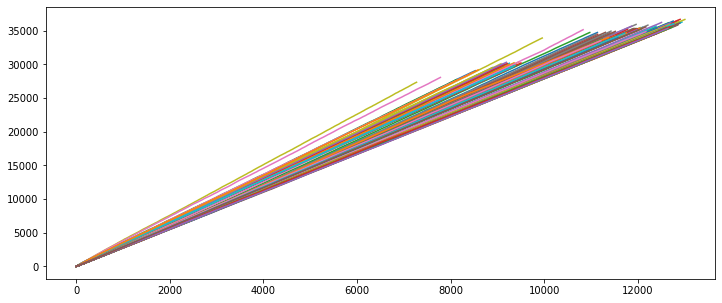

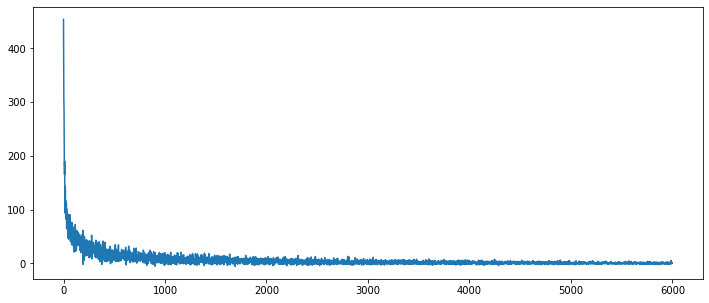

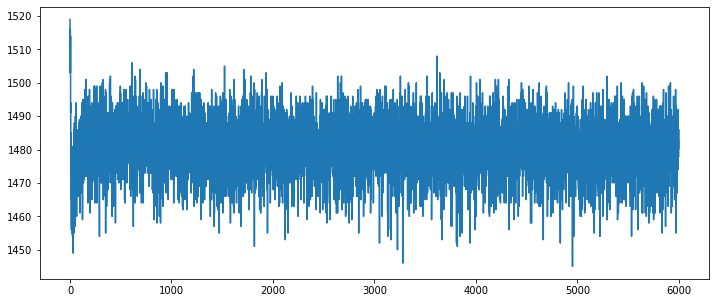

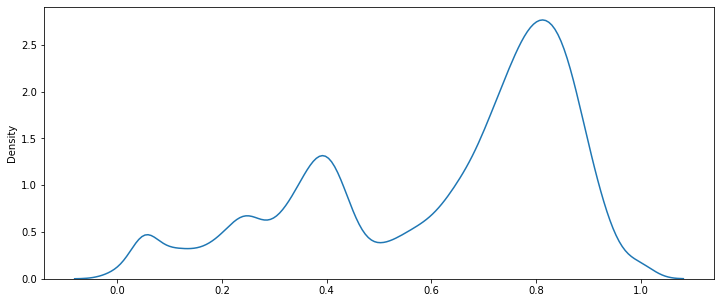

Run 5:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (43): 36476 (0.9394384716528734, CCCCCDCCCCCCCCCC)
WORST AGENT (213): 26895 (0.5735416915185494, DCDCCCCCCCCCCCCC)


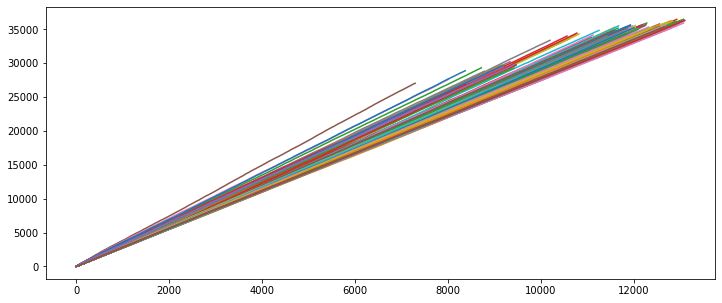

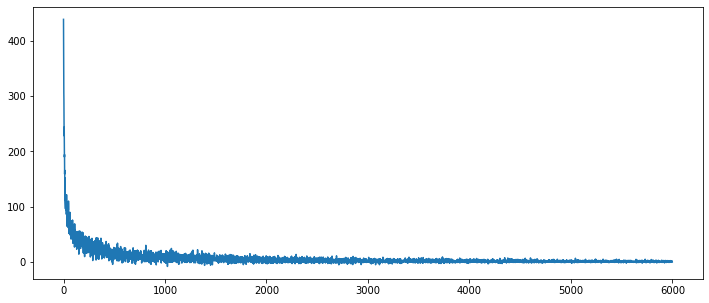

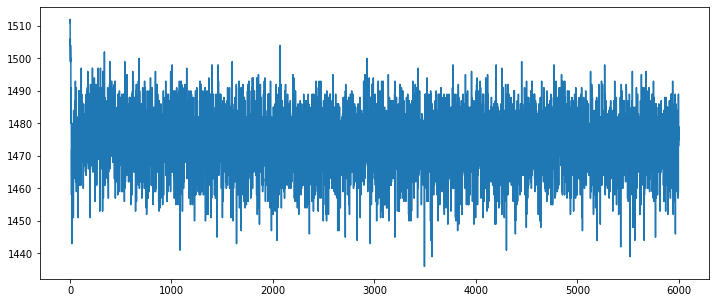

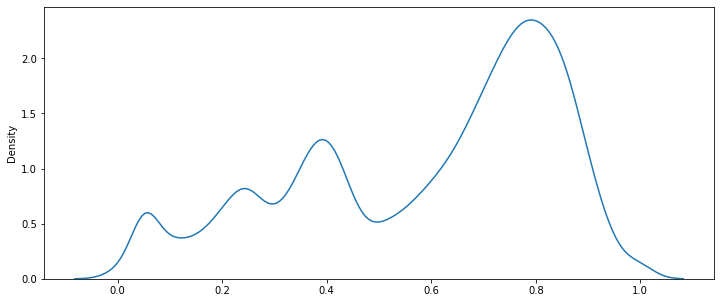

Run 6:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (157): 36982 (0.94862934807648, CCCCCCCCCCCCCCCC)
WORST AGENT (118): 27517 (0.5302690582959642, DCDCCCDCCDCCCDCC)


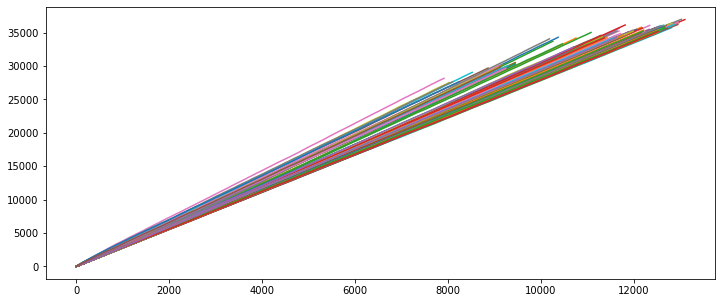

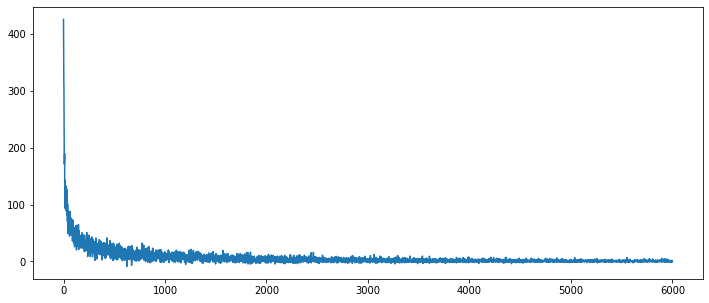

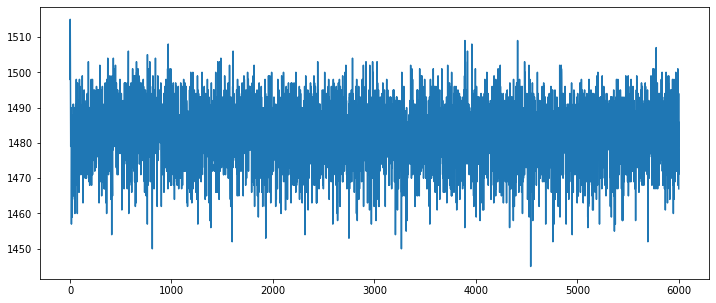

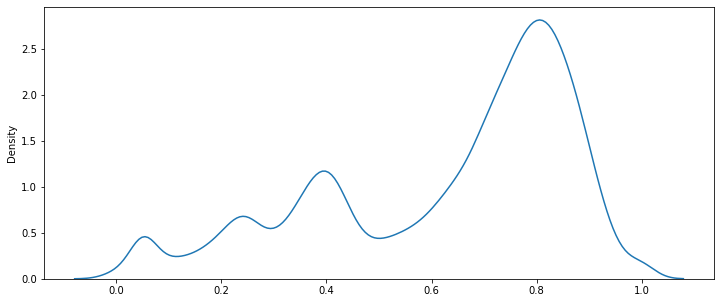

Run 7:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (5): 37503 (0.9451075800197674, CCCCCDCCCCCCCCCC)
WORST AGENT (39): 27404 (0.569860398520463, DCDCCCCCCCCCCCCC)


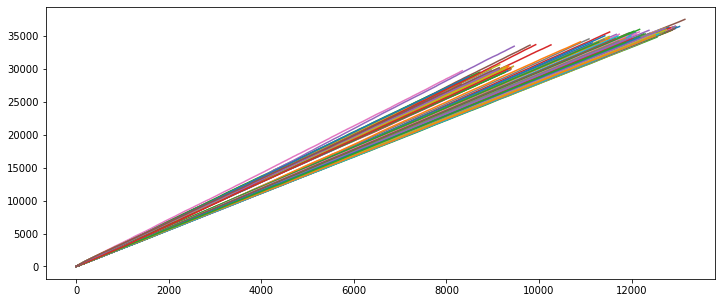

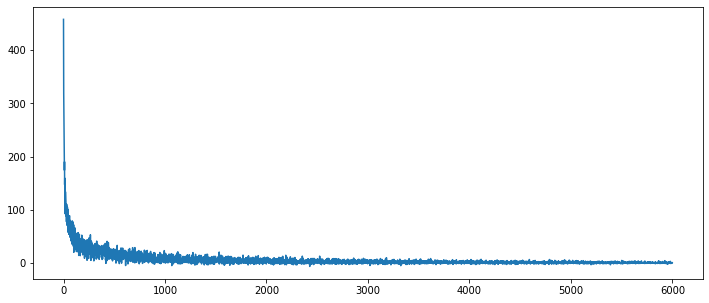

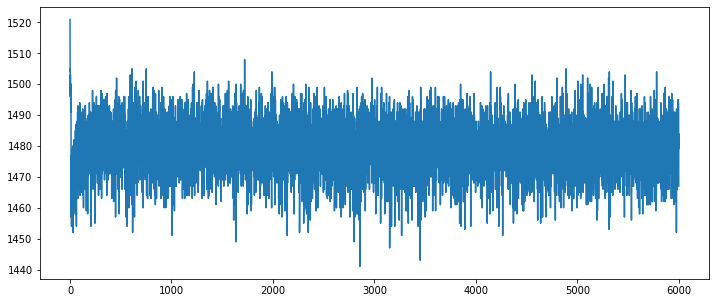

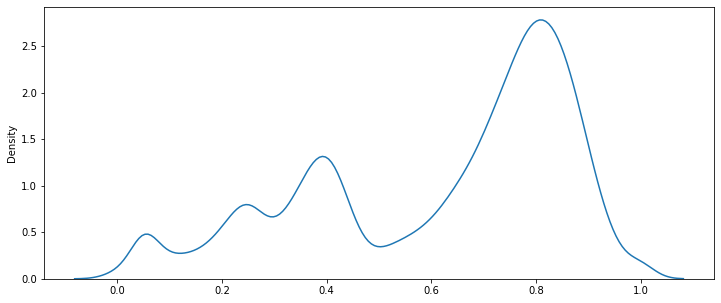

Run 8:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (106): 36618 (0.9501511745096519, CCCCCCCCCCCCCCCC)
WORST AGENT (74): 28204 (0.574784276126558, DCCCCCCCDCCCCCCC)


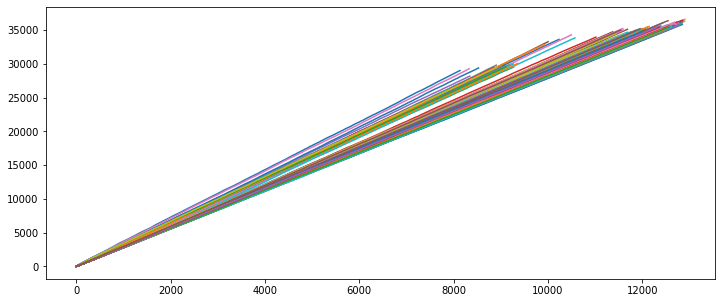

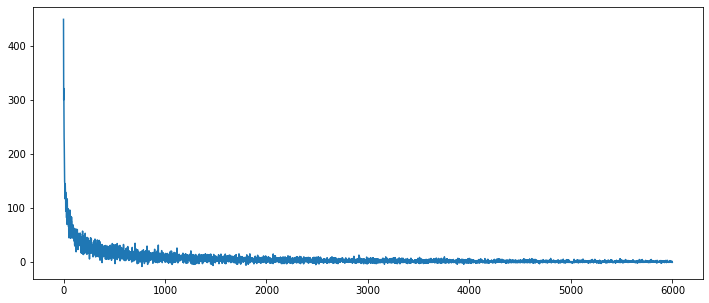

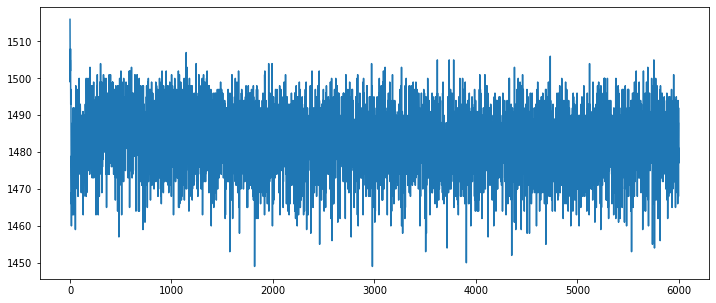

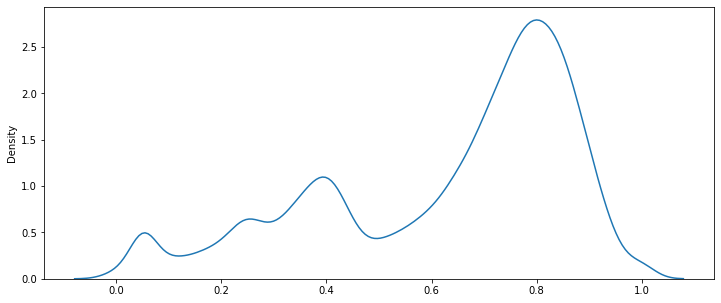

Run 9:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (100): 37170 (0.9509516286767472, CCCCCCCCCCCCCCCC)
WORST AGENT (49): 26541 (0.4898270600203459, DCDCCCCCDCCCCCCC)


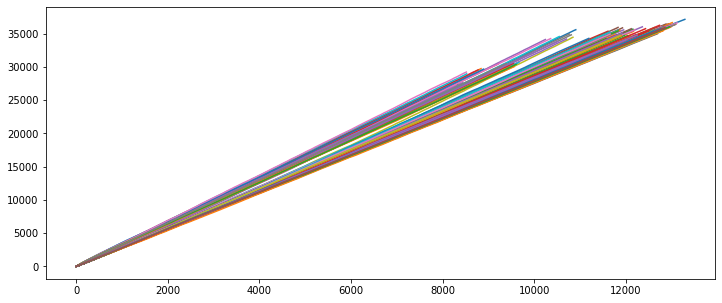

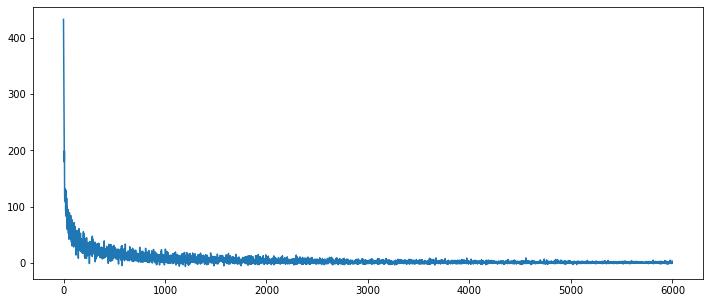

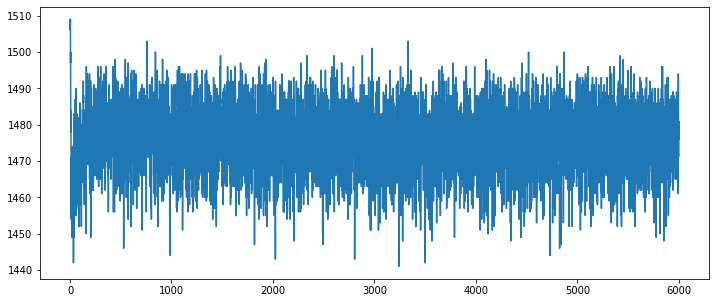

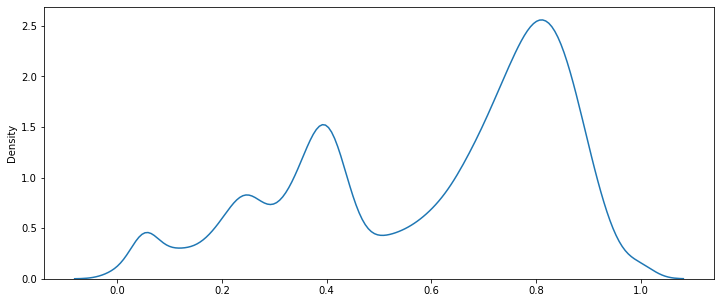

Run 10:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (101): 36736 (0.9504341812034119, CCCCCCCCCCCCCCCC)
WORST AGENT (176): 27572 (0.5616011505273251, DCDCCCCCCCCCCCDC)


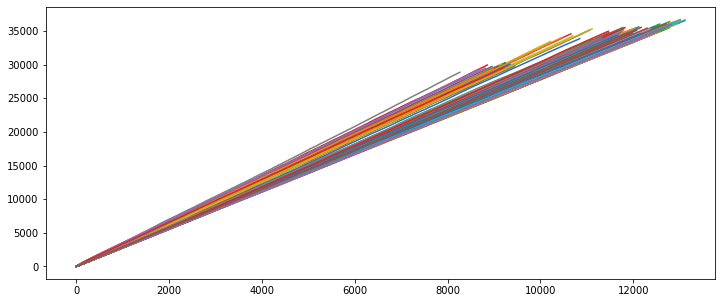

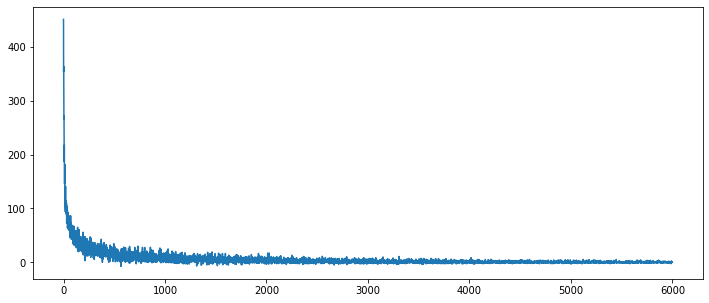

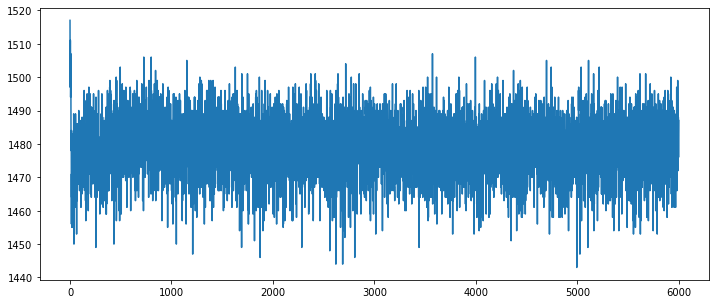

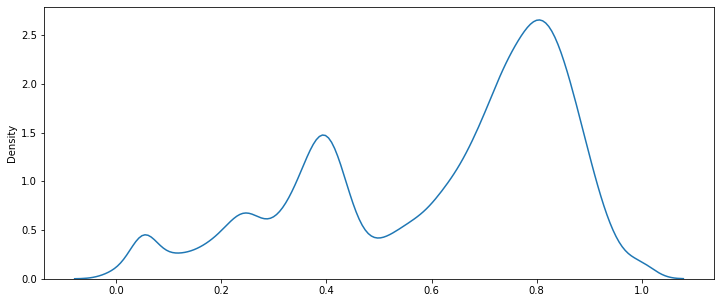

In [6]:
POPULATION = (256,)
ROUNDS = 6_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(10):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()

    M = sim.produce_weight_matrix()
    sns.kdeplot(M.ravel())

    plt.show()


In [7]:
sim.produce_weight_matrix()

array([[0.        , 0.86457371, 0.90809689, ..., 0.4982699 , 0.74040022,
        0.80539119],
       [0.86457371, 0.        , 0.8464    , ..., 0.46638905, 0.8233882 ,
        0.9025    ],
       [0.90809689, 0.8464    , 0.        , ..., 0.56828402, 0.77318668,
        0.75858481],
       ...,
       [0.4982699 , 0.46638905, 0.56828402, ..., 0.        , 0.68715374,
        0.50173611],
       [0.74040022, 0.8233882 , 0.77318668, ..., 0.68715374, 0.        ,
        0.84756866],
       [0.80539119, 0.9025    , 0.75858481, ..., 0.50173611, 0.84756866,
        0.        ]])

In [8]:
G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [9]:
# from datetime import datetime

# dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

# nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [10]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [11]:
M = sim.produce_weight_matrix()

M

array([[0.        , 0.86457371, 0.90809689, ..., 0.4982699 , 0.74040022,
        0.80539119],
       [0.86457371, 0.        , 0.8464    , ..., 0.46638905, 0.8233882 ,
        0.9025    ],
       [0.90809689, 0.8464    , 0.        , ..., 0.56828402, 0.77318668,
        0.75858481],
       ...,
       [0.4982699 , 0.46638905, 0.56828402, ..., 0.        , 0.68715374,
        0.50173611],
       [0.74040022, 0.8233882 , 0.77318668, ..., 0.68715374, 0.        ,
        0.84756866],
       [0.80539119, 0.9025    , 0.75858481, ..., 0.50173611, 0.84756866,
        0.        ]])

In [12]:
import seaborn as sns

In [13]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.86457371, 0.90809689, ..., 0.4982699 , 0.74040022,
        0.80539119],
       [0.86457371, 0.05      , 0.8464    , ..., 0.46638905, 0.8233882 ,
        0.9025    ],
       [0.90809689, 0.8464    , 0.05      , ..., 0.56828402, 0.77318668,
        0.75858481],
       ...,
       [0.4982699 , 0.46638905, 0.56828402, ..., 0.05      , 0.68715374,
        0.50173611],
       [0.74040022, 0.8233882 , 0.77318668, ..., 0.68715374, 0.05      ,
        0.84756866],
       [0.80539119, 0.9025    , 0.75858481, ..., 0.50173611, 0.84756866,
        0.05      ]])

In [14]:
# K = nx.Graph()
# K.add_weighted_edges_from([
#     (i, j, weights[i, j] + weights[j, i])
#     for i in range(POPULATION[0])
#     for j in range(i + 1, POPULATION[0])
#     if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
# ])

# nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [15]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>

In [16]:
cumulative_rewards[0][0]

101

In [17]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[286.83604736 222.02704026]
  [262.87624234  58.2106876 ]
  [237.10199647  19.30937275]
  [ 53.21408693   0.5       ]]

 [[277.34744539  73.92167899]
  [209.65050094   7.17675725]
  [131.05948412   0.52228524]
  [ 12.55615212   0.        ]]

 [[266.8609672   56.36044819]
  [146.15050759   8.1155009 ]
  [ 78.27533001   0.80944405]
  [  0.90856826   0.        ]]

 [[145.00497422   5.36803813]
  [ 17.39992462   0.74123048]
  [  9.31140597   0.        ]
  [  0.           0.        ]]]


In [18]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.COOPERATE: 0>

In [19]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[266.20284756 206.86068967]
  [243.09322179  54.24077533]
  [215.51693297  24.08065156]
  [ 38.02688454   0.3375    ]]

 [[256.72630688  75.86890547]
  [178.63504406   5.8731816 ]
  [173.16451352   3.32566829]
  [ 26.82130106   0.64932745]]

 [[253.04664456  63.78596747]
  [ 18.63247458  85.75454019]
  [ 88.82191827   2.90949261]
  [  0.           0.        ]]

 [[134.31064428  13.81572592]
  [ 36.58700743   0.28808474]
  [ 11.1737121    0.        ]
  [  2.43651602   0.        ]]]


In [20]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [21]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [22]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      CCCCCDCCCCCCCCCD
5.0                      CCCCCDCCCCCCCDCD
8.666666666666666        CCCCCDCCCCCCCCDC
10.0                     CCCDCDCDCCCCCCCC
11.0                     CCCDCCDDCCDCCCCC
12.0                     CCCDCCCCCCCDCCDC
16.0                     CCCDCCCCCDCCCDCC
16.0                     CCCDCCCDCCCCDCCD
23.0                     CCCCCDCCCCCDDCCC
24.0                     CCCDCDCCCCCCCCDC
28.0                     CCCCCDCCCDCDCCCC
37.666666666666664       CCCCCCCCCCCDCCDC
38.0                     CCCDCCCDCCCDCDCC
48.0                     CCCCCCCCDCCCCCDD
56.5                     CCCDCCCCCCCCCDCC
57.0                     CCCDCCCCCCDDCCCC
58.0                     CCCDCCDCCCCDCCCC
64.5                     CCCCCCDCCCDCCCCC
65.0                     CCCDCCDCCDCCCCCC
67.0                     CCCCCDCDCCCCCCCD
68.0                     CCCCCDCCCCCDCCCC
73.07692307692308        CCCCCCCCCCCCCCDC
74.0                     CCCCCCDCCCCDCDCC
75.25                    CCCDCDCCC

In [23]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

36700.0                  CCCCCDCCCCCCCCCD
36402.0                  CCCCCDCCCCCCCDCD
36303.333333333336       CCCCCDCCCCCCCCDC
36301.0                  CCCDCCCCCCCDCCDC
36294.5                  CCCDCDCDCCCCCCCC
36242.0                  CCCDCCDDCCDCCCCC
36191.0                  CCCDCCCDCCCCDCCD
36177.666666666664       CCCCCCCCCCCDCCDC
36120.0                  CCCDCCCCCDCCCDCC
36062.0                  CCCCCDCCCCCDDCCC
36054.0                  CCCCCDCCCDCDCCCC
36035.0                  CCCDCDCCCCCCCCDC
35932.0                  CCCCCCCCDCCCCCDD
35878.0                  CCCDCCCDCCCDCDCC
35811.0                  CCCDCCDCCDCCCCCC
35791.0                  CCCDCCCCCCCCCDCC
35780.666666666664       CCCDCCDCCCCDCCCC
35745.0                  CCCDCCCCCCDDCCCC
35744.0                  CCCCCCDCCCDCCCCC
35741.179487179485       CCCCCCCCCCCCCCDC
35701.7868852459         CCCCCDCCCCCCCCCC
35700.25                 CCCDCDCCCCCCCCCC
35693.0                  CCCCCDCDCCCCCCCD
35682.6                  CCCCCDCCC

In [24]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCCCCCCCCCCC'

In [25]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[286.83604736 222.02704026]
  [262.87624234  58.2106876 ]
  [237.10199647  19.30937275]
  [ 53.21408693   0.5       ]]

 [[277.34744539  73.92167899]
  [209.65050094   7.17675725]
  [131.05948412   0.52228524]
  [ 12.55615212   0.        ]]

 [[266.8609672   56.36044819]
  [146.15050759   8.1155009 ]
  [ 78.27533001   0.80944405]
  [  0.90856826   0.        ]]

 [[145.00497422   5.36803813]
  [ 17.39992462   0.74123048]
  [  9.31140597   0.        ]
  [  0.           0.        ]]]


In [26]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
